# **Date Fruit Classification**
In this project, we aim to classify different types of date fruits using machine learning techniques. The dataset consists of images of 9 different classes of dates.

In [18]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

## **Data Exploration**

In [19]:
train_dir = 'train'
test_dir = 'test'

print(f'There are {len(os.listdir(train_dir))} classes in the training set')
num_of_images = 0
for class_name in os.listdir(train_dir):
    print(f'There are {len(os.listdir(os.path.join(train_dir, class_name)))} images in {class_name} class')
    num_of_images += len(os.listdir(os.path.join(train_dir, class_name)))

print(f'There are {num_of_images} images in total in training set')
    

There are 9 classes in the training set
There are 122 images in Ajwa class
There are 133 images in Galaxy class
There are 94 images in Mejdool class
There are 162 images in Meneifi class
There are 123 images in NabtatAli class
There are 102 images in Rutab class
There are 119 images in Shaishe class
There are 184 images in Sokari class
There are 117 images in Sugaey class
There are 1156 images in total in training set


In [20]:
print(f'There are {len(os.listdir(test_dir))} classes in the test set')
num_of_images = 0
for class_name in os.listdir(test_dir):
    print(f'There are {len(os.listdir(os.path.join(test_dir, class_name)))} images in {class_name} class')
    num_of_images += len(os.listdir(os.path.join(test_dir, class_name)))
print(f'There are {num_of_images} images in total in test set') 

There are 9 classes in the test set
There are 53 images in Ajwa class
There are 57 images in Galaxy class
There are 41 images in Mejdool class
There are 70 images in Meneifi class
There are 54 images in NabtatAli class
There are 44 images in Rutab class
There are 52 images in Shaishe class
There are 80 images in Sokari class
There are 51 images in Sugaey class
There are 502 images in total in test set


### **Samples of The Data**

Sample of images in training set
Sample of Ajwa Dates


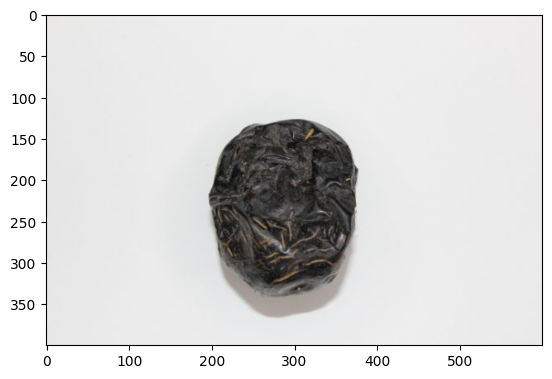

Sample of Galaxy Dates


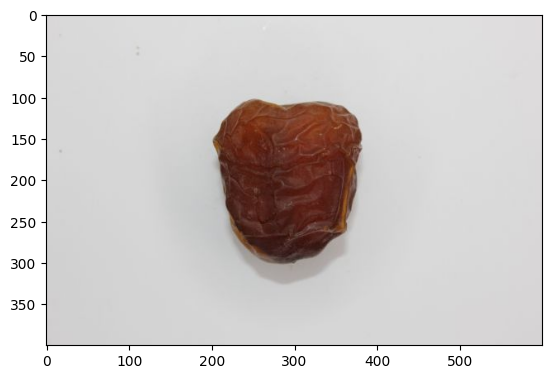

Sample of Sokari Dates


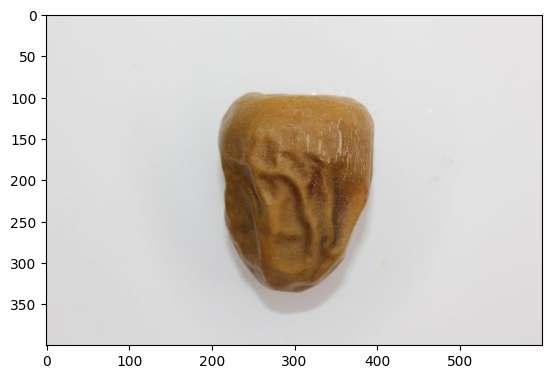

In [21]:
import matplotlib.pyplot as plt
print("Sample of images in training set")
print("Sample of Ajwa Dates")
ajwa_images = os.listdir(os.path.join(train_dir, 'Ajwa'))
plt.imshow(load_img(os.path.join(train_dir, 'Ajwa', ajwa_images[0])))
plt.show()
print("Sample of Galaxy Dates")
galaxy_images = os.listdir(os.path.join(train_dir, 'Galaxy'))
plt.imshow(load_img(os.path.join(train_dir, 'Galaxy', galaxy_images[0])))
plt.show()
print("Sample of Sokari Dates")
sokari_images = os.listdir(os.path.join(train_dir, 'Sokari'))
plt.imshow(load_img(os.path.join(train_dir, 'Sokari', sokari_images[0])))
plt.show()

### **Image Resolution Check**

In the upcoming steps, we'll be **reducing the resolution** of our images. This strategy helps us **decrease the number of trainable parameters**, thereby making our model more efficient. Importantly, we aim to achieve this **without compromising the accuracy** of our classification.

In [22]:
sample_img = load_img(os.path.join(train_dir, 'Ajwa', ajwa_images[0]))
img_array = img_to_array(sample_img)
print(f'Shape of image array: {img_array.shape}')

Shape of image array: (400, 600, 3)


## **Training and Validation Generators**
Will be using **ImageDataGenerators** to augment the data on the fly.

In [23]:
def train_val_generators(TRAINING_DIR):
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     validation_split=0.1,# Reserve 10% of the data for validation
                                     horizontal_flip=True,)

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      subset = 'training',
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(200, 200))

  validation_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                                subset = 'validation',
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(200, 200))
  return train_generator, validation_generator

In [ ]:
train_generator, validation_generator = train_val_generators(train_dir)

## **Training the Model**

With our dataset prepared and ready, we can now shift our focus towards constructing and training our machine learning model. This step involves defining the architecture of the model, compiling it, and then training it on our data. Will be using **transfer learning** to improve the model accuracy by taking weight from **MobileNet** which is a compact and effienct pre trained model.

In [25]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import SGD
# Load the MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(9, activation='softmax')
])

model.compile(optimizer=SGD(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

C:\Users\pcd\AppData\Local\Temp\ipykernel_26656\3808742433.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(200, 200, 3))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ ?                      │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

In [26]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.95):
      print("\nReached 95% validation accuracy so cancelling training!")
      self.model.stop_training = True

### Train the model with the optimal learning rate
Chose the following **learning rate** after many trial and errors.

In [27]:

callbacks = myCallback()
history = model.fit(train_generator, epochs=50, validation_data=validation_generator, callbacks=callbacks, verbose=2)

Epoch 1/50


c:\Users\pcd\Documents\GitHub\date-fruit-classification\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 - 11s - 334ms/step - accuracy: 0.5201 - loss: 1.6230 - val_accuracy: 0.8036 - val_loss: 0.6219
Epoch 2/50
33/33 - 9s - 268ms/step - accuracy: 0.8218 - loss: 0.5217 - val_accuracy: 0.8214 - val_loss: 0.4535
Epoch 3/50
33/33 - 9s - 265ms/step - accuracy: 0.8956 - loss: 0.3327 - val_accuracy: 0.8929 - val_loss: 0.4091
Epoch 4/50
33/33 - 9s - 273ms/step - accuracy: 0.9224 - loss: 0.2499 - val_accuracy: 0.8571 - val_loss: 0.3930
Epoch 5/50
33/33 - 9s - 286ms/step - accuracy: 0.9531 - loss: 0.1812 - val_accuracy: 0.9107 - val_loss: 0.3346
Epoch 6/50
33/33 - 9s - 275ms/step - accuracy: 0.9521 - loss: 0.1748 - val_accuracy: 0.8839 - val_loss: 0.3173
Epoch 7/50
33/33 - 9s - 260ms/step - accuracy: 0.9693 - loss: 0.1328 - val_accuracy: 0.8839 - val_loss: 0.3151
Epoch 8/50
33/33 - 9s - 264ms/step - accuracy: 0.9655 - loss: 0.1280 - val_accuracy: 0.9107 - val_loss: 0.3322
Epoch 9/50
33/33 - 9s - 260ms/step - accuracy: 0.9732 - loss: 0.1157 - val_accuracy: 0.9018 - val_loss: 0.3480
Epoch 10/50

## **Visualizing the Results**

In this section, we'll take a closer look at the outcomes of our model training. By visualizing these results, we can gain deeper insights into the performance of our model and identify potential areas for improvement.

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
# Training and validation accuracy
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
# Training and validation loss
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')


plt.show()

Found 502 images belonging to 9 classes.
502/502 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step
Classification Report:
              precision    recall  f1-score   support

        Ajwa       0.98      1.00      0.99        53
      Galaxy       0.96      0.96      0.96        57
     Mejdool       1.00      0.98      0.99        41
     Meneifi       0.90      0.90      0.90        70
   NabtatAli       0.93      1.00      0.96        54
       Rutab       0.95      0.95      0.95        44
     Shaishe       0.94      0.92      0.93        52
      Sokari       0.95      0.93      0.94        80
      Sugaey       0.96      0.94      0.95        51

    accuracy                           0.95       502
   macro avg       0.95      0.95      0.95       502
weighted avg       0.95      0.95      0.95       502

Confusion Matrix:


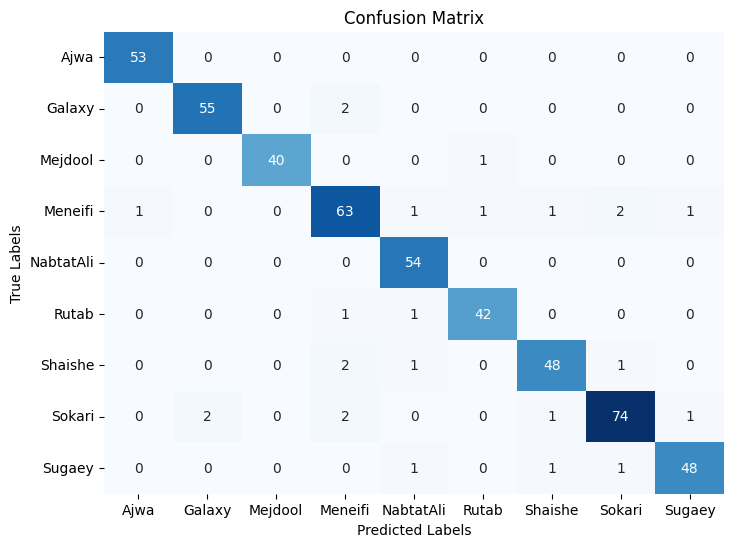

In [29]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(200, 200),
                                                  batch_size=1,
                                                  class_mode='categorical',
                                                  shuffle=False)
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
# Convert prediction probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
# Get class labels
class_labels = list(test_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

print("Confusion Matrix:")
matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, cbar=False, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## **Saving The Model**

In [30]:
history.model.save('model.keras')